# Clasificación de imágenes de gatos y perros

En este cuaderno, construiremos un modelo clasificador desde cero que sea capaz de distinguir perros de gatos. Seguiremos los siguientes pasos:

1. Explorar los datos de ejemplo
2. Construir un pequeño convnet desde cero para resolver nuestro problema de clasificación
3. Evaluar la precisión del entrenamiento y la validación

## Explorar los datos del ejemplo

Empecemos descargando nuestros datos de ejemplo, un .zip de 2.000 imágenes JPG de perros y gatos, y extrayéndolos localmente en /tmp.

*NOTA: Las 2.000 imágenes utilizadas en este ejercicio se han extraído del conjunto de datos "Perros vs. Gatos" disponible en Kaggle, que contiene 25.000 imágenes. Aquí utilizamos un subconjunto del conjunto de datos completo para reducir el tiempo de entrenamiento con fines educativos.*

In [24]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O cats_and_dogs/cats_and_dogs_filtered.zip

--2022-05-19 18:23:11--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.72.112, 142.250.80.16, 142.250.64.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.72.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs/cats_and_dogs_filtered.zip’

cats_and_dogs/cats_ 100%[===================>]  65.43M  4.92MB/s    in 17s     

2022-05-19 18:23:28 (3.80 MB/s) - ‘cats_and_dogs/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [25]:
import os
import zipfile

local_zip = 'cats_and_dogs/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('cats_and_dogs')
zip_ref.close()

El contenido del .zip se extrae al directorio base que contiene subdirectorios de entrenamiento y validación para los conjuntos de datos. Vamos a definir cada uno de estos directorios:

In [8]:
base_dir = 'cats_and_dogs/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Ahora, veamos cómo son los nombres de los archivos en los directorios del entrenamiento de los gatos y de los perros (las convenciones de denominación de los archivos son las mismas en el directorio de validación):

In [9]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.502.jpg', 'cat.774.jpg', 'cat.409.jpg', 'cat.1.jpg', 'cat.839.jpg', 'cat.648.jpg', 'cat.343.jpg', 'cat.685.jpg', 'cat.874.jpg', 'cat.722.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


In [10]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


Tanto para los gatos como para los perros, tenemos 1.000 imágenes de entrenamiento y 500 imágenes de prueba. Ahora vamos a ver algunas imágenes para tener una mejor idea de cómo son los conjuntos de datos de gatos y perros.

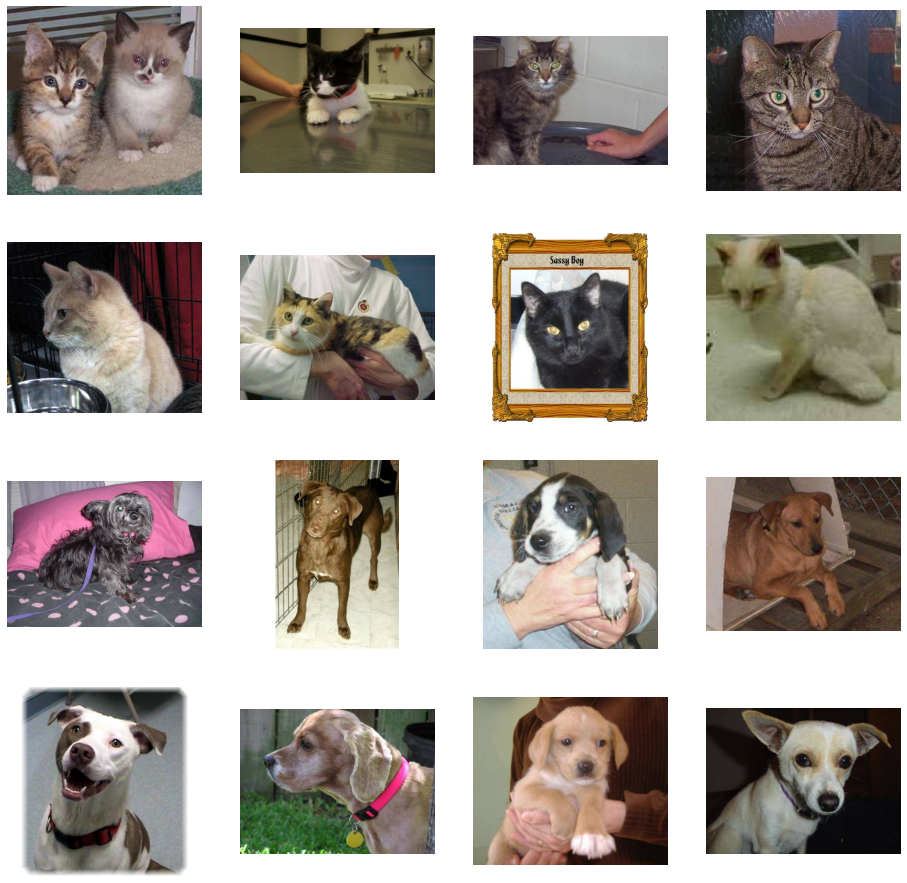

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Construyendo una Red neuronal convolucional desde cero para llegar al 72% de precisión

Las imágenes que entrarán en nuestra Red neuronal convolucional son imágenes en color de 150x150 (en la siguiente sección sobre el preprocesamiento de datos, añadiremos el manejo para redimensionar todas las imágenes a 150x150 antes de alimentarlas a la red neuronal).

Vamos a codificar la arquitectura. Apilaremos 3 módulos {convolución + relu + maxpooling}. Nuestras convoluciones operan en ventanas de 3x3 y nuestras capas de maxpooling operan en ventanas de 2x2. Nuestra primera convolución extrae 16 filtros, la siguiente extrae 32 filtros y la última extrae 64 filtros.

NOTA: Esta es una configuración ampliamente utilizada y que se sabe que funciona bien para la clasificación de imágenes. Además, dado que tenemos relativamente pocos ejemplos de entrenamiento (1.000), el uso de sólo tres módulos convolucionales mantiene el modelo pequeño, lo que reduce el riesgo de sobreajuste (que exploraremos en mayor profundidad en el Ejercicio 2.)

In [26]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [27]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

Encima pegamos dos capas totalmente conectadas. Como nos enfrentamos a un problema de clasificación de dos clases, es decir, a un problema de clasificación binaria, terminaremos nuestra red con una activación sigmoidea, de modo que la salida de nuestra red será un único escalar entre 0 y 1, que codifica la probabilidad de que la imagen actual sea de clase 1 (frente a la clase 0).

In [28]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

In [29]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        1849

La columna "Output Shape" muestra cómo evoluciona el tamaño de su mapa de características en cada capa sucesiva. Las capas de convolución reducen un poco el tamaño de los mapas de características debido al relleno, y cada capa de agrupación reduce a la mitad el mapa de características.

A continuación, configuraremos las especificaciones para el entrenamiento del modelo. Entrenaremos nuestro modelo con la pérdida binary_crossentropy, porque es un problema de clasificación binaria y nuestra activación final es una sigmoide. (Para refrescar las métricas de pérdida, véase el Curso acelerado de aprendizaje automático). Utilizaremos el optimizador rmsprop con una tasa de aprendizaje de 0,001. Durante el entrenamiento, querremos controlar la precisión de la clasificación.

*NOTA: En este caso, el uso del algoritmo de optimización RMSprop es preferible al descenso de gradiente estocástico (SGD), porque RMSprop automatiza el ajuste de la tasa de aprendizaje para nosotros. (Otros optimizadores, como Adam y Adagrad, también adaptan automáticamente la tasa de aprendizaje durante el entrenamiento, y funcionarían igualmente bien aquí).*

In [30]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

## Preprocesamiento de datos

Vamos a configurar los generadores de datos que leerán las imágenes en nuestras carpetas de origen, las convertirán en tensores float32 y las alimentarán (con sus etiquetas) a nuestra red. Tendremos un generador para las imágenes de entrenamiento y otro para las de validación. Nuestros generadores producirán lotes de 20 imágenes de tamaño 150x150 y sus etiquetas (binarias).

Como ya sabrás, los datos que se introducen en las redes neuronales suelen estar normalizados de alguna manera para que sean más fáciles de procesar por la red. (En nuestro caso, preprocesaremos nuestras imágenes normalizando los valores de los píxeles para que estén en el rango [0, 1] (originalmente todos los valores están en el rango [0, 255]).

En Keras esto se puede hacer a través de la clase `keras.preprocessing.image.ImageDataGenerator` utilizando el parámetro rescale. Esta clase ImageDataGenerator permite instanciar generadores de lotes de imágenes aumentadas (y sus etiquetas) mediante .flow(data, labels) o .flow_from_directory(directory). Estos generadores pueden ser utilizados con los métodos del modelo Keras que aceptan generadores de datos como entradas: `fit_generator`, `evaluate_generator` y `predict_generator`.

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Entrenamiento

Entrenemos con las 2.000 imágenes disponibles, durante 15 epochs, y validemos con las 1.000 imágenes de validación. (Esto puede tardar unos minutos en ejecutarse).

In [32]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/15
100/100 - 8s - loss: 0.7890 - acc: 0.5475 - val_loss: 0.6779 - val_acc: 0.5270 - 8s/epoch - 83ms/step
Epoch 2/15
100/100 - 7s - loss: 0.6621 - acc: 0.6380 - val_loss: 0.6152 - val_acc: 0.6670 - 7s/epoch - 69ms/step
Epoch 3/15
100/100 - 7s - loss: 0.5560 - acc: 0.7135 - val_loss: 0.6499 - val_acc: 0.6720 - 7s/epoch - 69ms/step
Epoch 4/15
100/100 - 7s - loss: 0.4538 - acc: 0.7830 - val_loss: 0.8071 - val_acc: 0.5910 - 7s/epoch - 68ms/step
Epoch 5/15
100/100 - 7s - loss: 0.3503 - acc: 0.8420 - val_loss: 0.6649 - val_acc: 0.7190 - 7s/epoch - 68ms/step
Epoch 6/15
100/100 - 7s - loss: 0.2530 - acc: 0.8925 - val_loss: 0.8539 - val_acc: 0.6890 - 7s/epoch - 69ms/step
Epoch 7/15
100/100 - 7s - loss: 0.1719 - acc: 0.9410 - val_loss: 0.9964 - val_acc: 0.7190 - 7s/epoch - 70ms/step
Epoch 8/15
100/100 - 7s - loss: 0.1218 - acc: 0.9560 - val_loss: 1.0779 - val_acc: 0.6890 - 7s/epoch - 68ms/step
Epoch 9/15
100/100 - 7s - loss: 0.0814 - acc: 0.9705 - val_loss: 1.1752 - val_acc: 0.6860 - 7s/e

## Visualización de las representaciones intermedias
Para tener una idea de qué tipo de características ha aprendido nuestra Red neuronal convolucional, una cosa divertida es visualizar cómo se transforma una entrada a medida que pasa por la Red neuronal convolucional.

Escojamos una imagen aleatoria de un gato o un perro del conjunto de entrenamiento, y generemos una figura en la que cada fila sea la salida de una capa, y cada imagen de la fila sea un filtro específico en ese mapa de características de salida. Vuelva a ejecutar esta celda para generar representaciones intermedias para una variedad de imágenes de entrenamiento.

1/1 [==============================] - 0s 221ms/step


/tmp/ipykernel_217/788551056.py:43: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


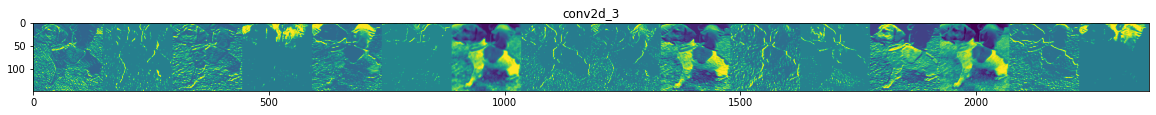

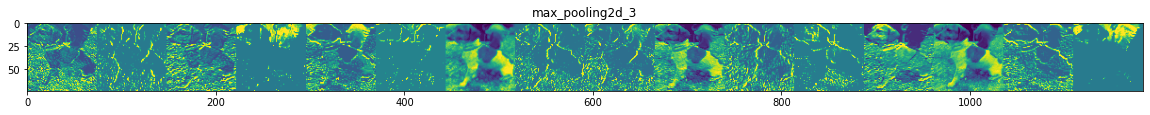

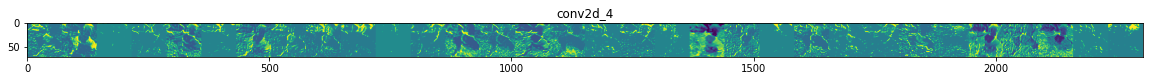

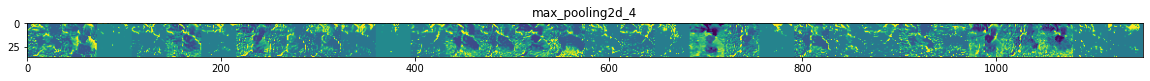

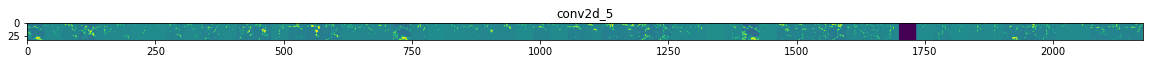

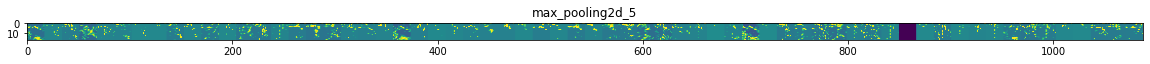

In [33]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

Como se puede ver, pasamos de los píxeles brutos de las imágenes a representaciones cada vez más abstractas y compactas. Las representaciones que van descendiendo empiezan a destacar aquello a lo que la red presta atención, y muestran cada vez menos rasgos que se "activan"; la mayoría se ponen a cero. Esto se llama "sparsity". La escasez de representaciones es una característica clave del aprendizaje profundo.

Estas representaciones llevan cada vez menos información sobre los píxeles originales de la imagen, pero una información cada vez más refinada sobre la clase de la imagen. Se puede pensar en una Red neuronal convolucional (o en una red profunda en general) como una tubería de destilación de información.

### Evaluación de la precisión y las pérdidas del modelo

Vamos a trazar la precisión y la pérdida de entrenamiento/validación tal y como se recogen durante el entrenamiento:

Text(0.5, 1.0, 'Training and validation loss')

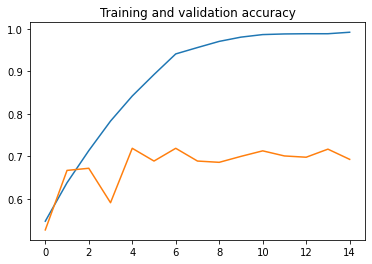

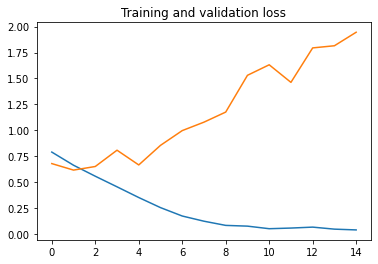

In [34]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

Como puedes ver, estamos sobreajustando como si estuviera pasando de moda. Nuestra precisión de entrenamiento (en azul) se acerca al 100% (!) mientras que nuestra precisión de validación (en verde) se estanca en el 70%. Nuestra pérdida de validación alcanza su mínimo después de sólo cinco épocas.

Dado que tenemos un número relativamente pequeño de ejemplos de entrenamiento (2000), la sobreadaptación debería ser nuestra principal preocupación. La sobreadaptación se produce cuando un modelo expuesto a muy pocos ejemplos aprende patrones que no se generalizan a los nuevos datos, es decir, cuando el modelo empieza a utilizar características irrelevantes para hacer predicciones. Por ejemplo, si usted, como humano, sólo ve tres imágenes de personas que son leñadores y tres imágenes de personas que son marineros, y entre ellas la única persona que lleva una gorra es un leñador, podría empezar a pensar que llevar una gorra es un signo de ser un leñador en contraposición a un marinero. En ese caso, sería un pésimo clasificador de leñadores y marineros.

La sobreadaptación es el problema central del aprendizaje automático: dado que estamos ajustando los parámetros de nuestro modelo a un conjunto de datos determinado, ¿cómo podemos asegurarnos de que las representaciones aprendidas por el modelo serán aplicables a datos nunca vistos? ¿Cómo evitamos aprender cosas que son específicas de los datos de entrenamiento?

## Explorando el aumento de datos
Vamos a familiarizarnos con el concepto de aumento de datos, una forma esencial de luchar contra el sobreajuste de los modelos de visión por ordenador.

Para aprovechar al máximo nuestros pocos ejemplos de entrenamiento, los "aumentaremos" mediante una serie de transformaciones aleatorias, de modo que en el momento del entrenamiento, nuestro modelo nunca verá exactamente la misma imagen dos veces. Esto ayuda a evitar el sobreajuste y a que el modelo se generalice mejor.

Esto se puede hacer configurando un número de transformaciones aleatorias que se realizarán en las imágenes leídas por nuestra instancia ImageDataGenerator. Empecemos con un ejemplo:

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

Estas son sólo algunas de las opciones disponibles (para más, consulte la documentación de Keras). Repasemos rápidamente lo que acabamos de escribir:

* `rotation_range` es un valor en grados (0-180), un rango dentro del cual rotar aleatoriamente las imágenes.
* `width_shift` y `height_shift` son rangos (como una fracción de la anchura o la altura total) dentro de los cuales traducir aleatoriamente las imágenes vertical u horizontalmente.
* `shear_range` es para aplicar aleatoriamente transformaciones de cizallamiento.
* `zoom_range` es para aplicar aleatoriamente el zoom dentro de las imágenes.
* `horizontal_flip` es para voltear aleatoriamente la mitad de las imágenes horizontalmente. Esto es relevante cuando no hay supuestos de asimetría horizontal (por ejemplo, imágenes del mundo real).
* `fill_mode` es la estrategia utilizada para rellenar los píxeles recién creados, que pueden aparecer después de una rotación o un cambio de ancho/altura.

Echemos un vistazo a nuestras imágenes aumentadas.

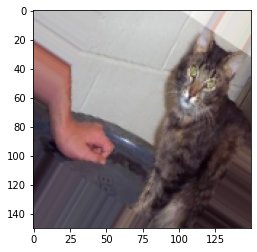

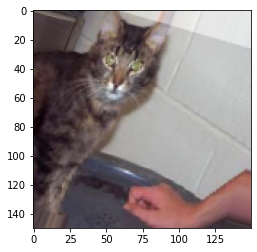

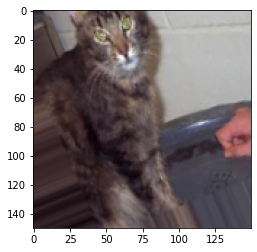

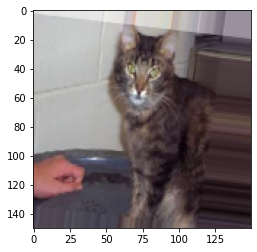

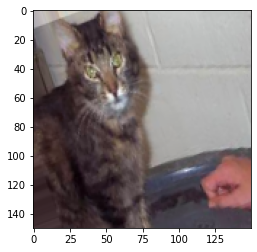

In [37]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

img_path = os.path.join(train_cats_dir, train_cat_fnames[2])
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# The .flow() command below generates batches of randomly transformed images
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 5 == 0:
    break

## Añadir el aumento de datos al paso de preprocesamiento
Ahora vamos a añadir nuestras transformaciones de aumento de datos de Exploring Data Augmentation a nuestra configuración de preprocesamiento de datos:

In [38]:
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 32 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Si entrenamos una nueva red utilizando esta configuración de aumento de datos, nuestra red nunca verá la misma entrada dos veces. Sin embargo, las entradas que ve siguen estando muy interrelacionadas, por lo que es posible que esto no sea suficiente para deshacerse por completo del sobreajuste.

## Añadir Dropout

Otra estrategia popular para luchar contra el sobreajuste es el uso de *dropout*.

El *dropout* es una forma eficiente de realizar promedios de modelos con redes neuronales. El término dropout significa "abandonar" u omitir aleatoriamente neuronas durante el proceso de entrenamiento de una red neuronal.

Entonces vamos a reconfigurar nuestra arquitectura neuronal convolucional para añadir un poco de *dropout*, justo antes de la capa de clasificación final:

In [39]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(img_input, output)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

## Volver a entrenar el modelo

Con el aumento de datos y el *dropout*, vamos a volver a entrenar nuestro modelo convolucional. Esta vez, vamos a entrenar en las 2.000 imágenes disponibles, durante 30 épocas, y validar en las 1.000 imágenes de validación. (Esto puede tardar unos minutos en ejecutarse.) Mira si puedes escribir el código tú mismo:

In [40]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/30
100/100 - 21s - loss: 0.7506 - acc: 0.5130 - val_loss: 0.6833 - val_acc: 0.5570 - 21s/epoch - 213ms/step
Epoch 2/30
100/100 - 20s - loss: 0.6967 - acc: 0.5780 - val_loss: 0.6466 - val_acc: 0.6350 - 20s/epoch - 197ms/step
Epoch 3/30
100/100 - 20s - loss: 0.6724 - acc: 0.5920 - val_loss: 0.6341 - val_acc: 0.5890 - 20s/epoch - 198ms/step
Epoch 4/30
100/100 - 20s - loss: 0.6444 - acc: 0.6375 - val_loss: 0.6117 - val_acc: 0.6620 - 20s/epoch - 199ms/step
Epoch 5/30
100/100 - 19s - loss: 0.6459 - acc: 0.6345 - val_loss: 0.6965 - val_acc: 0.6020 - 19s/epoch - 194ms/step
Epoch 6/30
100/100 - 20s - loss: 0.6305 - acc: 0.6505 - val_loss: 0.5941 - val_acc: 0.6710 - 20s/epoch - 202ms/step
Epoch 7/30
100/100 - 20s - loss: 0.6197 - acc: 0.6660 - val_loss: 0.5702 - val_acc: 0.6900 - 20s/epoch - 199ms/step
Epoch 8/30
100/100 - 20s - loss: 0.6174 - acc: 0.6610 - val_loss: 0.5408 - val_acc: 0.7180 - 20s/epoch - 199ms/step
Epoch 9/30
100/100 - 19s - loss: 0.6028 - acc: 0.6825 - val_loss: 0.5625

##### Tenga en cuenta que, con el aumento de datos, las 2.000 imágenes de entrenamiento se transforman aleatoriamente cada vez que se ejecuta un nuevo epoch de entrenamiento, lo que significa que el modelo nunca verá la misma imagen dos veces durante el entrenamiento.

## Evaluar los resultados

Vamos a evaluar los resultados del entrenamiento del modelo con aumento de datos y el *dropout*:

Text(0.5, 1.0, 'Training and validation loss')

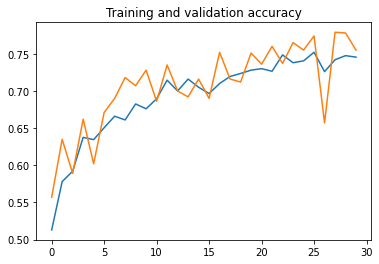

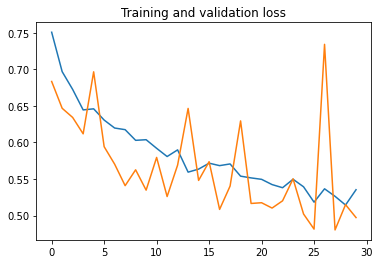

In [41]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

Mucho mejor. Ya no estamos ajustando en exceso y hemos ganado unos 3 puntos de porcentaje de precisión en la validación (véase la línea verde en el gráfico superior). De hecho, a juzgar por nuestro perfil de entrenamiento, podríamos seguir ajustando nuestro modelo durante más de 30 épocas y probablemente podríamos llegar al ~80%.

## Extracción de características utilizando un modelo preentrenado
Una cosa que se suele hacer en visión por computador es tomar un modelo entrenado en un conjunto de datos muy grande, ejecutarlo en su propio conjunto de datos más pequeño y extraer las representaciones intermedias (características) que el modelo genera. Estas representaciones suelen ser informativas para su propia tarea de visión por computador, aunque la tarea pueda ser muy diferente del problema para el que se entrenó el modelo original. Esta versatilidad y reutilización de las redes convolucionales es uno de los aspectos más interesantes del aprendizaje profundo.

En nuestro caso, utilizaremos el modelo Inception V3 desarrollado en Google, y preentrenado en ImageNet, un gran conjunto de datos de imágenes web (1,4M de imágenes y 1000 clases). Se trata de un modelo potente; veamos qué pueden hacer las características que ha aprendido para nuestro problema del gato frente al perro.

En primer lugar, tenemos que elegir qué capa intermedia de Inception V3 vamos a utilizar para la extracción de características. Una práctica común es utilizar la salida de la última capa antes de la operación de aplanamiento, la llamada "capa cuello de botella". El razonamiento aquí es que las siguientes capas totalmente conectadas serán demasiado especializadas para la tarea en la que la red fue entrenada, y por lo tanto las características aprendidas por estas capas no serán muy útiles para una nueva tarea. Las características del cuello de botella, sin embargo, conservan mucha generalidad.

Instanciemos un modelo Inception V3 precargado con pesos entrenados en ImageNet:

In [42]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-05-19 19:04:58--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.65.176, 142.250.65.208, 142.251.40.176, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.65.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  22.5MB/s    in 3.7s    

2022-05-19 19:05:02 (22.5 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [43]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

Al especificar el argumento `include_top=False`, cargamos una red que no incluye las capas de clasificación en la parte superior, ideal para la extracción de características.

Hagamos que el modelo no sea entrenable, ya que sólo lo utilizaremos para la extracción de características; no actualizaremos los pesos del modelo preentrenado durante el entrenamiento.

In [44]:
for layer in pre_trained_model.layers:
  layer.trainable = False

La capa que utilizaremos para la extracción de características en Inception v3 se llama `mixed7`. No es el cuello de botella de la red, pero la utilizamos para mantener un mapa de características suficientemente grande (7x7 en este caso). (El uso de la capa cuello de botella habría dado como resultado un mapa de características de 3x3, que es un poco pequeño). Vamos a obtener la salida de `mixed7`:

In [45]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


Ahora pongamos un clasificador totalmente conectado sobre last_output:

In [46]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

Por último, vamos a entrenar el modelo utilizando las características que hemos extraído. Entrenaremos con las 2.000 imágenes disponibles, durante 2 epoch, y validaremos con las 1.000 imágenes de validación.

In [47]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=2,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/2
100/100 - 27s - loss: 0.3500 - acc: 0.8710 - val_loss: 0.1202 - val_acc: 0.9540 - 27s/epoch - 272ms/step
Epoch 2/2
100/100 - 21s - loss: 0.2176 - acc: 0.9230 - val_loss: 0.1557 - val_acc: 0.9440 - 21s/epoch - 207ms/step


Puedes ver que alcanzamos una precisión de validación del 88-90% muy rápidamente. Esto es mucho mejor que el pequeño modelo que entrenamos desde cero.

## Mejora de la precisión ajustando el modelo

En nuestro experimento de extracción de características, sólo probamos a añadir dos capas de clasificación sobre una capa de Inception V3. Los pesos de la red preentrenada no se actualizaron durante el entrenamiento. Una forma de aumentar el rendimiento aún más es "afinar" los pesos de las capas superiores del modelo preentrenado junto con el entrenamiento del clasificador de nivel superior. Un par de notas importantes sobre el ajuste fino:

- El ajuste fino sólo debe intentarse *después* de haber entrenado el clasificador de nivel superior con el modelo preentrenado configurado como no entrenable**. Si añades un clasificador inicializado aleatoriamente sobre un modelo preentrenado e intentas entrenar todas las capas conjuntamente, la magnitud de las actualizaciones del gradiente será demasiado grande (debido a los pesos aleatorios del clasificador), y tu modelo preentrenado simplemente olvidará todo lo que ha aprendido.
- Además, **afinamos sólo las *capas superiores* del modelo preentrenado** en lugar de todas las capas del modelo preentrenado porque, en una Red neuronal convolucional, cuanto más alta es una capa, más especializada es. Las primeras capas de una red neuronal convolucional aprenden características muy simples y genéricas, que se generalizan a casi todos los tipos de imágenes. Pero a medida que se asciende, las características son cada vez más específicas para el conjunto de datos con el que se ha entrenado el modelo. El objetivo del ajuste fino es adaptar estas características especializadas para que funcionen con el nuevo conjunto de datos.

Todo lo que tenemos que hacer para implementar el ajuste fino es configurar las capas superiores de Inception V3 para que sean entrenables, recompilar el modelo (necesario para que estos cambios surtan efecto) y reanudar el entrenamiento. Descongelemos todas las capas que pertenecen al módulo `mixed7` -es decir, todas las capas que se encuentran después de `mixed6` - y volvamos a compilar el modelo:

In [49]:
from tensorflow.keras.optimizers import SGD

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
model.compile(loss='binary_crossentropy',
              optimizer=SGD(
                  learning_rate=0.00001, 
                  momentum=0.9),
              metrics=['acc'])

Ahora vamos a volver a entrenar el modelo. Entrenaremos con las 2.000 imágenes disponibles, durante 50 épocas, y validaremos con las 1.000 imágenes de validación. (Esto puede tardar entre 15 y 20 minutos en ejecutarse).

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Estamos viendo una buena mejora, ya que la pérdida de validación pasa de ~1,7 a ~1,2, y la precisión pasa del 88% al 92%. Esto supone una mejora relativa del 4,5% en la precisión.

Vamos a trazar la pérdida y la precisión de entrenamiento y validación para mostrarlo de forma concluyente:

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

#### ¡Enhorabuena! Mediante la extracción de características y el ajuste fino, has construido un modelo de clasificación de imágenes que puede identificar los gatos frente a los perros en las imágenes con una precisión superior al 90%.